In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [26]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


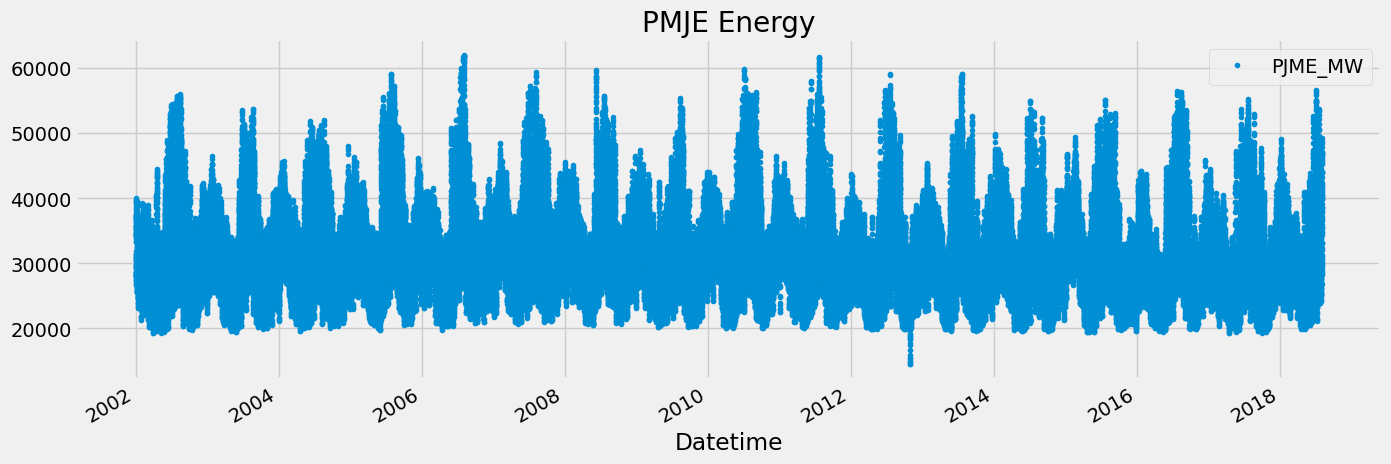

In [27]:
df.plot(style = '.', figsize = (15,5), color = color_pal[0], title='PMJE Energy')
plt.show()

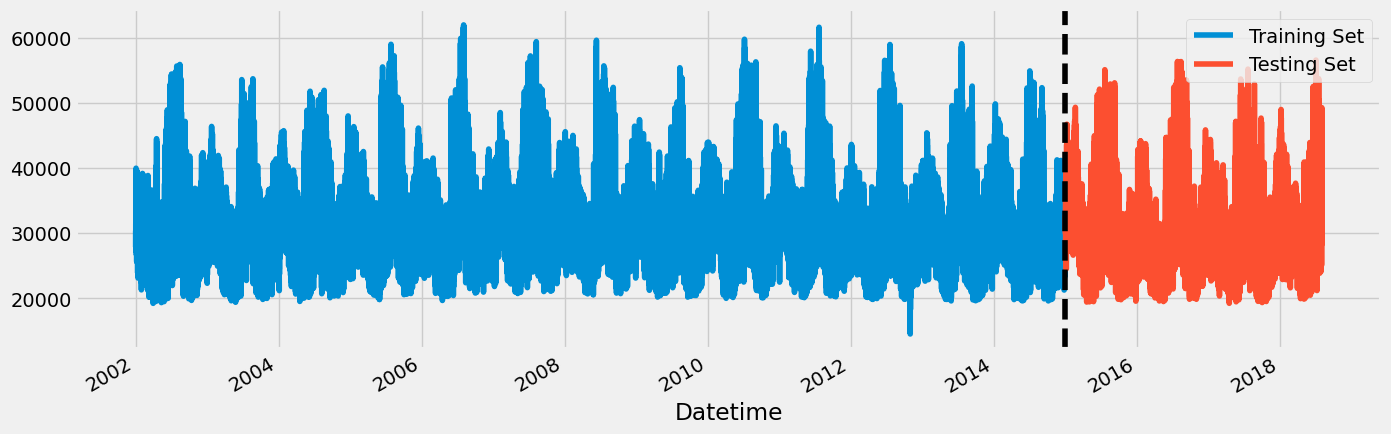

In [30]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax = ax, label = 'Training Set')
test.plot(ax = ax, label = 'Testing Set')
ax.axvline('01-01-2015', color = 'black', ls = '--')
plt.legend(['Training Set', 'Testing Set'])
plt.show()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:56: UserWarning: Parsing '25-12-2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp_method(other, operator.gt)


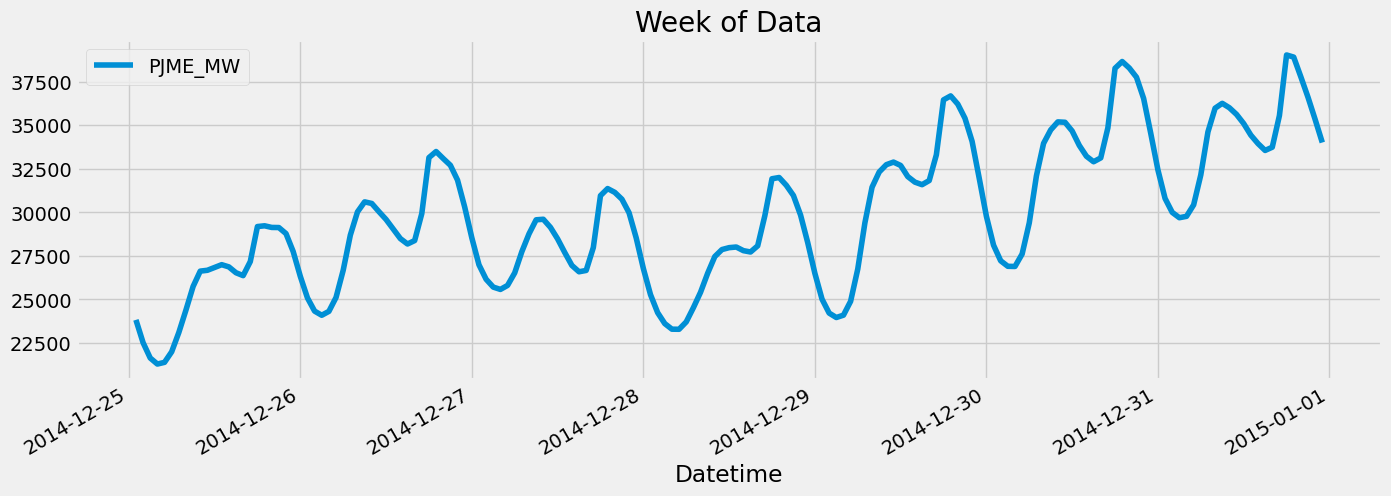

In [34]:
df.loc[(df.index > '25-12-2014') & (df.index < '01-01-2015')].plot(figsize=(15,5), title = 'Week of Data')
plt.show()

In [38]:
def creature_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day_of_year
    return df

df = creature_features(df)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


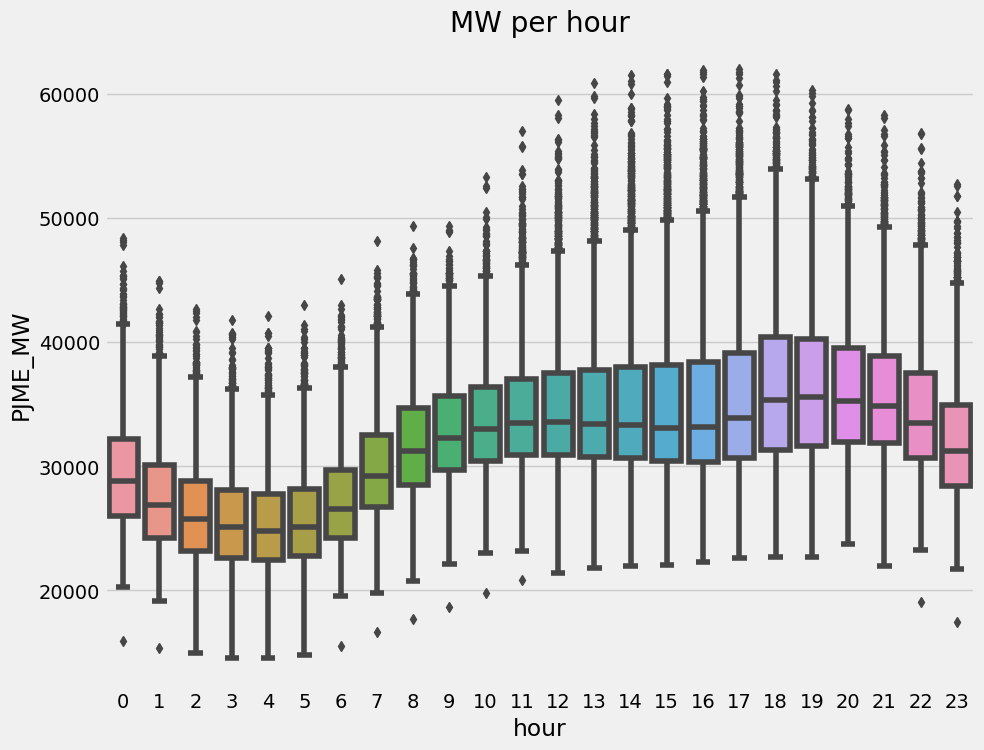

In [40]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW per hour')
plt.show()

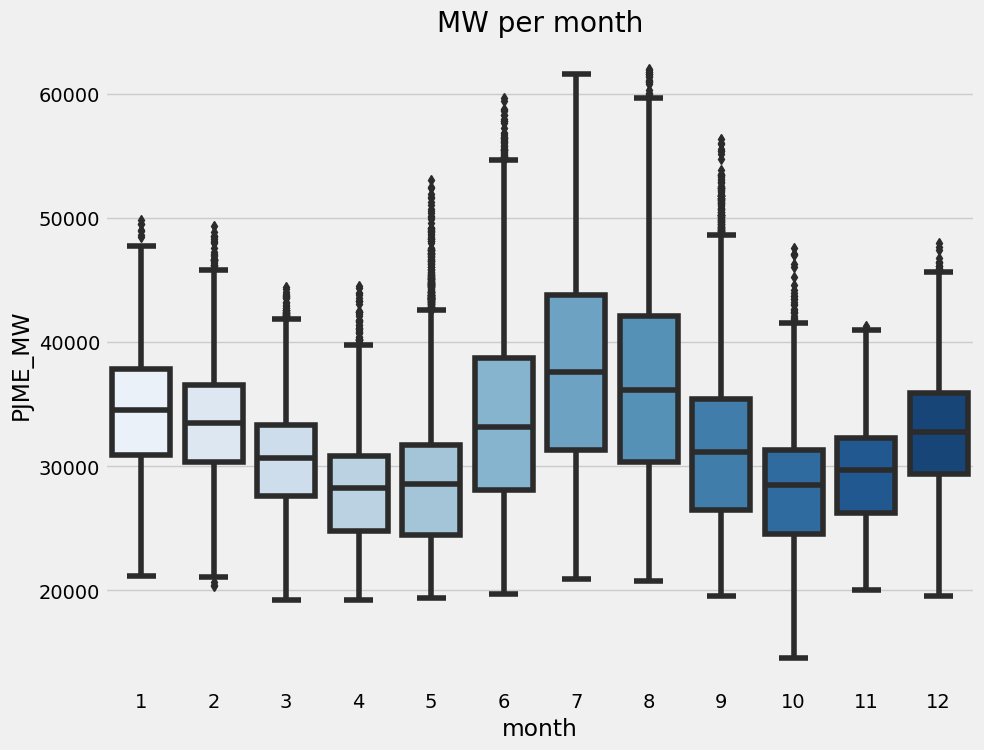

In [41]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW per month')
plt.show()

In [45]:
train = creature_features(train)
test = creature_features(test)
Features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
Target = 'PJME_MW'

In [47]:
X_train, y_train = train[Features], train[Target]
X_test, y_test = test[Features], test[Target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((113926, 6), (113926,), (31440, 6), (31440,))

In [51]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50, learning_rate = 0.01)
reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.13873	validation_1-rmse:11517.66004
[200]	validation_0-rmse:5373.33346	validation_1-rmse:5165.30811
[300]	validation_0-rmse:3375.20923	validation_1-rmse:3829.25476
[400]	validation_0-rmse:2882.55200	validation_1-rmse:3715.04915
[436]	validation_0-rmse:2795.05547	validation_1-rmse:3726.59616


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [54]:
h = pd.DataFrame(data = reg.feature_importances_, index=reg.feature_names_in_, columns = ['importance'])

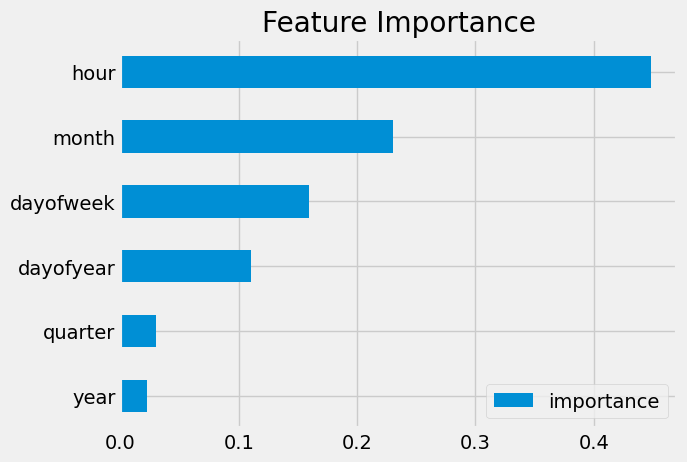

In [56]:
h.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')
plt.show()

In [59]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction_x,prediction_y,prediction
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,41014.218750,41014.218750,41014.218750
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,40507.140625,40507.140625,40507.140625
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,38933.621094,38933.621094,38933.621094


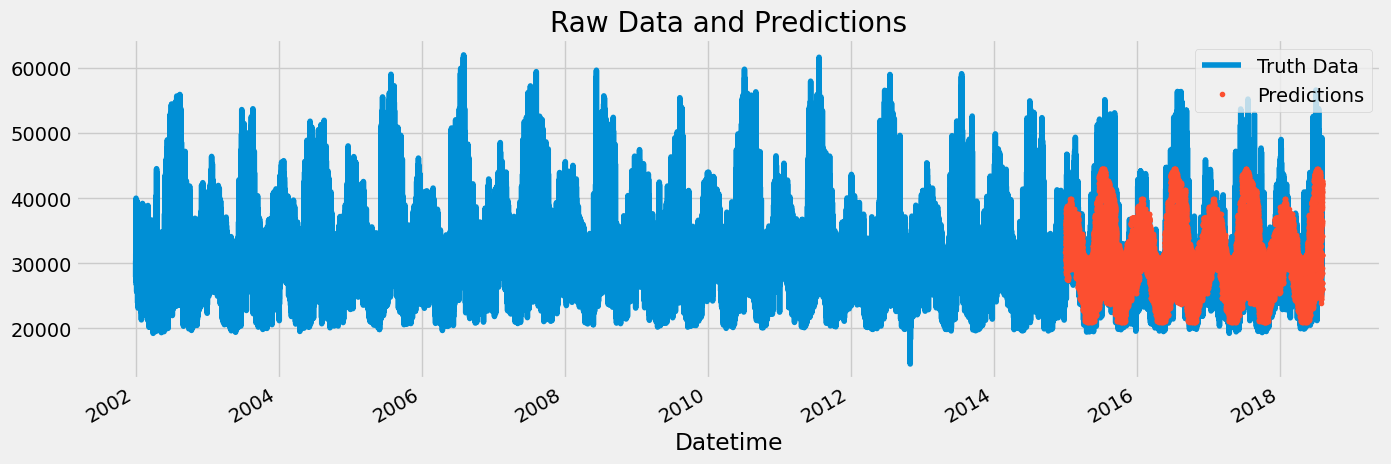

In [60]:
ax = df[['PJME_MW']].plot(figsize = (15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

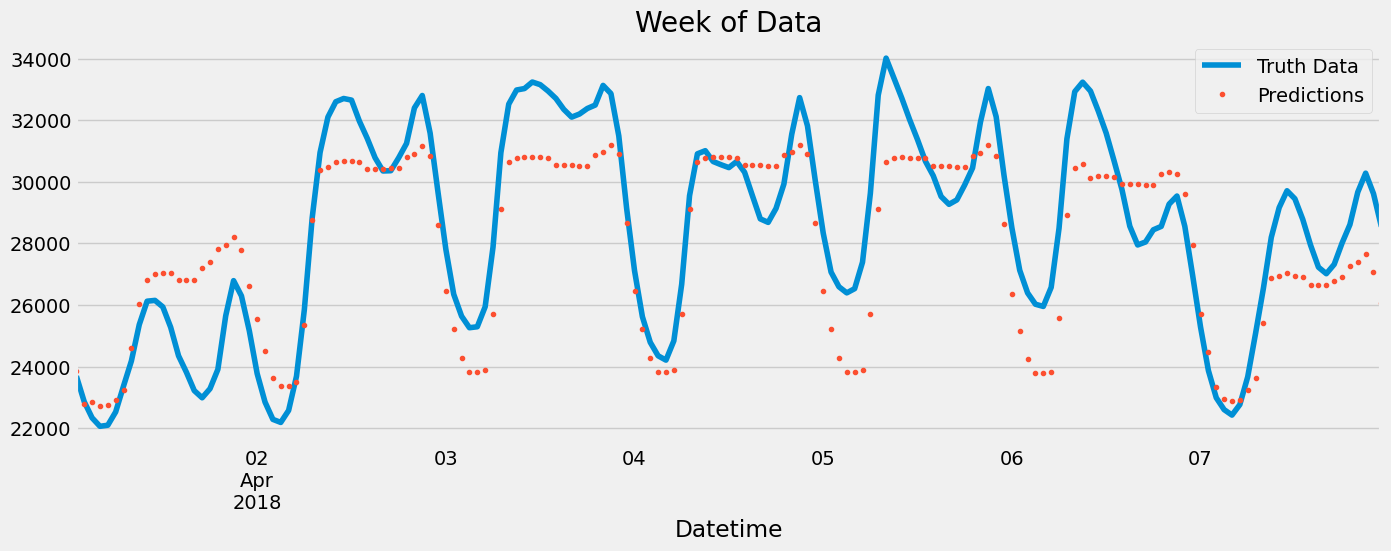

In [72]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'].plot(figsize=(15,5), title = 'Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style = '.')
plt.legend(['Truth Data', 'Predictions'])
plt.show()

In [66]:
np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))

3714.530191611067